In [ ]:
!pip install transformers

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
import torch
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
def read_data(txt_path):
  with open(txt_path, 'r') as f:
    txt_data = f.readlines()
  return txt_data

movie_ratings_data_path = "/content/Movie_Ratings(Naver).txt"   #이거 수정! 경로수정하시고

movie_ratings_data = read_data(movie_ratings_data_path) #data 바로 쓰면 되어요

In [ ]:
# Preprocessing Data
# 각 줄에서 첫 번째 탭 문자 이전의 내용을 제거함 -> id 제거
# 이거는 Movie data 전처리라서 빼도 될거예요

def preprocess_data(txt_lines) :
  processed_lines = [] # 전처리된 문장이 저장될 공간

  for line in txt_lines:
      if '\t' in line:
          processed_lines.append(line.split('\t', 1)[1])
      else:
          processed_lines.append(line)

  final_data = []
  label = [] #긍정/부정 label -> 0:neg 1:pos
  for line in processed_lines:
      if '\t' in line:
          final_data.append(line.split('\t', 1)[0])
          label.append(line.split('\t', 1)[1][0])
      else:
          final_data.append(line)
  return final_data

movie_ratings_data = preprocess_data(movie_ratings_data)
movie_ratings_data = movie_ratings_data[:10000]

In [ ]:
import torch

class TextSet:
  def __init__(self, text_data, tokenizer, batch_len=8):
    self.text_in_a_string = "".join(text_data).replace('\n', ' ')
    self.tokenizer = tokenizer
    self.tokenized_corpus = self.tokenizer(self.text_in_a_string)['input_ids']
    self.batch_len = batch_len
    self.tokenized_corpus = self.tokenized_corpus[:len(self.tokenized_corpus)//self.batch_len*self.batch_len]
    self.corpus_tensor = self._batchify_text()

  def _batchify_text(self):
    entire_corpus_tensor = torch.LongTensor(self.tokenized_corpus)
    return entire_corpus_tensor.reshape(-1, self.batch_len)

  def __len__(self):
    return len(self.corpus_tensor)

  def __getitem__(self, idx):
    return self.corpus_tensor[idx]



In [ ]:
'''
define train_loader
'''

from torch.utils.data import DataLoader
train_set = TextSet(movie_ratings_data, tokenizer, batch_len=32)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

100%|██████████| 500/500 [02:31<00:00,  3.31it/s]


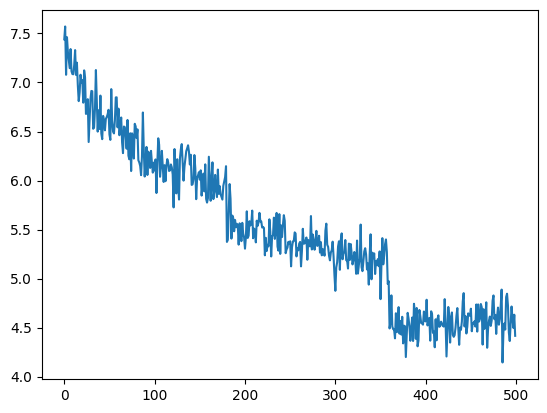

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

'''
Use CUDA (NVIDIA GPU) to train your model
'''

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_record = []
model.cuda()
num_iteration = 500 # you can change num updates here

'''
In your report, briefly explain how this training loop trains a language model
'''
train_iter = iter(train_loader)

for i in tqdm(range(num_iteration)):
  try:
    batch = next(train_iter)
  except StopIteration:
    train_iter = iter(train_loader)
    batch = next(train_iter)
  out = model(batch.cuda()).logits
  out = torch.log_softmax(out, dim=-1)
  correct_next_word = batch[:, 1:]
  out_flatten = out[:, :-1, :].reshape(-1, out.shape[-1])
  correct_next_word = correct_next_word.reshape(-1)

  log_prob_of_correct_word = out_flatten[torch.arange(len(correct_next_word)), correct_next_word]

  loss = -log_prob_of_correct_word.mean()
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()
  loss_record.append(loss.item())

plt.plot(loss_record)

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

### Generate Test


In [ ]:
import torch
import random


def generate_sentence(prompt, max_length=max_len, temperature=0.9):
    # 입력 문장을 토크나이징
    #torch.manual_seed(42)
    random.seed(42)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').cuda()

    # 문장 생성
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(torch.device("cuda:0")),
            max_length=max_length,
            temperature=temperature,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1,
            do_sample=True,  # 샘플링 활성화
            top_k=50,        # top_k 토큰 중에서 선택
            top_p=0.95
        )

    # 생성된 문장 디코딩
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = generated_text.replace("\n", " ")
    generated_text = generated_text.replace('"', "")
    generated_text = generated_text.replace("'", "")
    return generated_text


In [ ]:
generate_sentence("바보아님", 20, temperature=0.9)

'바보아님..마지막 장면에서 마냥 웃는 장면..정말 재밌었다..'

In [ ]:
def make_acrostic(org):
  max_len = 10
  org_clean = org.replace(" ", "")
  syllables = list(org_clean)
  num_lines = len(syllables)
  print("====================================")
  print("prompt :", org)
  print("syllables :", syllables)
  print("max length of each sentence:", max_len)
  print("number of lines :", num_lines)

  generated_sentence = [""]
  lens = [0]

  for idx_n_letter in enumerate(syllables):
    i = idx_n_letter[0] #index
    one_letter = idx_n_letter[1] #실제 값


    concat_sentence = ""
    for one_sentence in generated_sentence:
      concat_sentence += one_sentence

    prompt = concat_sentence + one_letter
    # random.seed(30)
    # print(i, "prompt :", prompt)
    out = generate_sentence(prompt, max_length=max_len*(i+1))
    lens.append(len(out))
    # print(" ", "out :", out)
    # print(" ", "to save :", out[lens[i]:lens[i+1]])
    generated_sentence.append(out[lens[i]:lens[i+1]])

  print("---")
  del generated_sentence[0]
  for one_row in generated_sentence:
    print(one_row)

  # print(lens)


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 바보아님
prompt : 바보아님
syllables : ['바', '보', '아', '님']
max length of each sentence: 10
number of lines : 4
first : 0, second : 바
first : 1, second : 보
first : 2, second : 아
first : 3, second : 님
---
바랍니다! 정말 재미있게 본 영화
보단 재밌는데...마지막에 살짝
아련한것같다...정말 
님..정말 웃김,!!!!


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 개극혐
prompt : 개극혐
syllables : ['개', '극', '혐']
max length of each sentence: 10
number of lines : 3
first : 0, second : 개
first : 1, second : 극
first : 2, second : 혐
---
개재미있어요~~재밌음
극중 제일 멋있었는데 재밌게 본
혐지스럽지않다!!!!!


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 개극혐
prompt : 개극혐
syllables : ['개', '극', '혐']
max length of each sentence: 10
number of lines : 3
---
개쩜 재밌었네요. 왜 평점을
극삭임???지극히빙
혐지스럽게 잘생겼다 ᄏᄏ


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 노잼
prompt : 노잼
syllables : ['노', '잼']
max length of each sentence: 10
number of lines : 2
---
노마!!!기대안하고봤
잼이네요ᄒᄒᄒ ᅲ너
